# Cluster parameters optimization

We wish to study the behaviour of the parallelization in our code. In order to do so we apply all the transoformation to the dataset, timing each stage of the processing to compare different configurations, mainly the number of cores and the number of partitions used in the process. Since using all the dataset was a quite heavy task we decided to restrict to one hardware analysis. SW-088 was the hardware of choice. All the functions used in the following code are found in the file **Functions.py**.

In [26]:
spark.stop()

In [27]:
%load_ext autoreload
%autoreload 2

# Standard libraries
import os
import numpy as np
import pandas as pd
from math import ceil
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc
from pyspark import StorageLevel
import seaborn as sns




#Import all functions (improve readibility)
from Functions import *

# PySpark core
from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import IntegerType

# PySpark functions
from pyspark.sql.functions import (
    coalesce,
    col, lit, expr, when, count, sum as spark_sum, abs as spark_abs,
    round as spark_round, min as spark_min, max as spark_max, avg as spark_avg,
    first, last, lag, row_number, desc, asc,
    explode, sequence, from_unixtime, to_date, unix_timestamp,
    window, min_by, mode, concat, monotonically_increasing_id
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
sensors = ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 
           'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 
           'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 
           'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 
           'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 
           'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 
           'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 
           'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']
alarms = ['A5', 'A9', 'ComError']
engines = ["S117", "S118", "S169", "S170"]
list_hwid = ['SW-106', 'SW-065', 'SW-115', 'SW-088']



frequency = 60
nCores = [16]
nPartitions = [16]
nExecutors = [2, 4, 6, 8] 
MEMexec = "2200m" 

loops = [1]
for loop in loops:
    OptimizationResults = {}
    for core in nCores:
        for partition in nPartitions:
    
            clear_output(wait=True)
    
            #----------------------CREATING DATAFRAME --------------------------
            
            TimeResults = {}
            
            #Create spark session
            print(f'Creating Spark session for {(core, partition)}')
            spark = CreateSparkSession(core, partition, MEMexec, log = False)
    
            print('Reading the CSV...')
            startTime = time.time()
            df = spark.read.option("header", True).option("inferSchema", True).csv("file:///mnt/shared/dataset.csv").repartition(partition, col("hwid"))
    
            #Convert milliseconds into seconds
            df = df.withColumn("when", spark_round(col("when") / 1000).cast(IntegerType()))
            df.count()
            endTime = time.time()
    
            TimeResults['LoadCSV'] = endTime - startTime
            print('Load CSV time: ', np.round(endTime - startTime, 2), ' seconds')
    
    
            #----------------------PREPROCESSING PIPELINE--------------------------
    
            
            print('Pivot dataset...')
    
            startTime = time.time()
            #df = df.filter(col('hwid') == 'SW-088')
            df_all_hw = (df.groupBy("hwid", "when")
                       .pivot("metric")
                       .agg(first("value"))
                       .withColumn("time", from_unixtime(col("when")))
                       .orderBy("hwid", "when"))
    
            print('Persist the dataframe...')
            df_all_hw = df_all_hw.persist()
            df_all_hw.count()
            
            endTime = time.time()
    
            TimeResults['Pivot'] = endTime - startTime
            print('Pivot time: ', np.round(endTime - startTime, 2), ' seconds')
    
            
            # Fill sensor gaps and build blocks of independent measurement
            print('Starting preprocessing...')
            
            startTime = time.time()
            #Create grid, homogeneous data
            df_grid = CreateGrid(df_all_hw, interval=frequency)
    
            #Build independent blocks
            df_blocks = BuildBlocks(df_grid, max_interval = 1800, sensors = sensors )
    
            #Fill the NULL values
            df_blocks = FillNull(df_blocks, sensors + engines, max_gap=240)
            
            df_blocks = df_blocks.persist()
            df_blocks.count()
            
            endTime = time.time()
    
            TimeResults['Preprocessing'] = endTime - startTime
    
            print('Preprocessing time: ', np.round(endTime - startTime, 2), ' seconds')
    
            df_all_hw.unpersist()
    
            #----------------------ANOMALY DETECTION--------------------------
            #print('Importing the dataset')
            #df_blocks = spark.read.parquet("/mnt/shared/df_blocks.parquet")
            #df_blocks = df_blocks.withColumn("A5", col("A5").cast("int"))
            #df_blocks = df_blocks.withColumn("A9", col("A9").cast("int"))
    
            useless_sensors, useful_sensors = UsefulSensors(df_blocks, sensors)
    
            #Compute the anomalies for all the hardware sequentially (parallelized internally)
            print('Starting Anomaly detection...')
            startTime = time.time()
    
            df_anomalies = detect_anomalies(df = df_blocks, time_separator = 60*40, threshold = 8, sensors = engines, partition = partition).persist()
            df_anomalies.count()
    
            endTime = time.time()
    
            TimeResults['AnomalyDetection'] = endTime - startTime
    
            print('Anomaly detection time: ', np.round(endTime - startTime, 2), ' seconds')
    
            #------------------------CORRELATIONS--------------------------
            print('Starting computing Correlations...')
    
            startTime = time.time()
    
            #df_blocks = spark.createDataFrame(df_blocks.rdd, df_blocks.schema)
            #df_anomalies = spark.createDataFrame(df_anomalies.rdd, df_anomalies.schema)
            
            joined_df = df_blocks.join(df_anomalies, on =["hwid", 'when', *engines, 'BlockID'], how='left').persist()
            joined_df.count()
    
            for i in list_hwid:
                filter_hw = joined_df.filter(col('hwid') == i)
                anomaly_corr = correlations(filter_hw, useful_sensors, 'flag_anomaly')
                
            endTime = time.time()
    
            TimeResults['Correlations'] = endTime - startTime
            print('Correlation time: ', np.round(endTime - startTime, 2), ' seconds')
    
    
            #------------------------PREDICTIVE MAINTEINANCE--------------------------
    
            print('Starting Predictive Mainteinance...')
            startTime1 = time.time()
    
            df_alarms = extract_alarms(df_blocks.select("when","A5","A9"), columns=["A5", "A9"], bits=[6, 7, 8] ).persist()
            df_alarms.count()
    
            endTime1 = time.time()
            
            list_df_final = {}
            
            df_final = joined_df.join(df_alarms.select('when', 'overheating') , on=['when'], how='left' )
    
            startTime2 = time.time()
            
            #Computing correlations
            alarm_corr = correlations(df_final, useful_sensors, 'overheating')

            df_final = df_final.filter(col("hwid") == "SW-088")
    
            #Computing the predictive dataframe on overheating signals
            target = "overheating"
            df_final088 = add_predictive(df_final, target, window_before_heating=30, debug=False, join=True, partition = partition )
            df_final088.count()
    
            endTime2 = time.time()
    
            TimeResults['Predictive Maintenance'] = (endTime1 - startTime1) + (endTime2 - startTime2)
            print('Predictive Maintenance time: ', np.round((endTime1 - startTime1) + (endTime2 - startTime2), 2), ' seconds')
    
            #-----------------------------------Saving the results 
            
            OptimizationResults[(core, partition)] = TimeResults
    
            data = []
            for (cores, partition), metrics in OptimizationResults.items():
                row = {'Resources': (cores, partition)}
                row.update(metrics)
                data.append(row)
            
            df_alt = pd.DataFrame(data)
            df_alt.to_pickle(f'SC_4HW_{loop}.pkl')
    
            #-----------------------------------Clean up the memory
    
            try:
                df_blocks.unpersist()
                df_anomalies.unpersist()
                df_alarms.unpersist()
                
                
                #Garbage collection
                gc.collect()
                
                #Clear Spark cache
                spark.catalog.clearCache()
                
            except Exception as cleanup_error:
                print(f"Cleanup error: {cleanup_error}")
    
            spark.stop()
            time.sleep(5)    

Creating Spark session for (16, 16)
Reading the CSV...


Load CSV time:  34.28  seconds
Pivot dataset...


Persist the dataframe...


25/08/29 16:58:38 WARN TaskSetManager: Lost task 0.0 in stage 25.0 (TID 210) (10.67.22.135 executor 2): java.io.IOException: No space left on device
	at java.base/java.io.FileOutputStream.writeBytes(Native Method)
	at java.base/java.io.FileOutputStream.write(FileOutputStream.java:349)
	at org.apache.spark.storage.TimeTrackingOutputStream.write(TimeTrackingOutputStream.java:59)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:225)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:178)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:345)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillWriter.write(UnsafeSorterSpillWriter.java:136)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.spillIterator(

Pivot time:  385.77  seconds
Starting preprocessing...


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `NextDiff_s` cannot be resolved. Did you mean one of the following? [`NextDiff`, `PrevDiff`, `hwid`, `A5`, `A9`].;
'Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, CASE WHEN isnotnull(P1#280766) THEN P1#280766 WHEN (('NextDiff_s <= 240) AND ('NextDiff_s <= 'PrevDiff_s)) THEN lead(P1#280766, 1, null) windowspecdefinition(hwid#256422, BlockID#791985L, hwid#256422 ASC NULLS FIRST, when#790866L ASC NULLS FIRST, specifiedwindowframe(RowFrame, 1, 1)) WHEN ('PrevDiff_s <= 240) THEN lag(P1#280766, -1, null) windowspecdefinition(hwid#256422, BlockID#791985L, hwid#256422 ASC NULLS FIRST, when#790866L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) END AS P1#792271, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, Prev_TimeStamp#791279L, Next_TimeStamp#791418L, PrevDiff#791558L, NextDiff#791699L, BlockID#791985L]
+- Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, Prev_TimeStamp#791279L, Next_TimeStamp#791418L, PrevDiff#791558L, NextDiff#791699L, BlockID#791985L]
   +- Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, Prev_TimeStamp#791279L, Next_TimeStamp#791418L, PrevDiff#791558L, NextDiff#791699L, CheckNewBlock#791841, BlockID#791985L]
      +- Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, Prev_TimeStamp#791279L, Next_TimeStamp#791418L, PrevDiff#791558L, NextDiff#791699L, CheckNewBlock#791841, BlockID#791985L, BlockID#791985L]
         +- Window [sum(CheckNewBlock#791841) windowspecdefinition(hwid#256422, when#790866L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS BlockID#791985L], [hwid#256422], [when#790866L ASC NULLS FIRST]
            +- Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, Prev_TimeStamp#791279L, Next_TimeStamp#791418L, PrevDiff#791558L, NextDiff#791699L, CheckNewBlock#791841]
               +- Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, Prev_TimeStamp#791279L, Next_TimeStamp#791418L, PrevDiff#791558L, NextDiff#791699L, CASE WHEN (PrevDiff#791558L > cast(1800 as bigint)) THEN 1 ELSE 0 END AS CheckNewBlock#791841]
                  +- Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, Prev_TimeStamp#791279L, Next_TimeStamp#791418L, PrevDiff#791558L, (Next_TimeStamp#791418L - when#790866L) AS NextDiff#791699L]
                     +- Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, Prev_TimeStamp#791279L, Next_TimeStamp#791418L, (when#790866L - Prev_TimeStamp#791279L) AS PrevDiff#791558L]
                        +- Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, Prev_TimeStamp#791279L, Next_TimeStamp#791418L]
                           +- Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, Prev_TimeStamp#791279L, Next_TimeStamp#791418L, Next_TimeStamp#791418L]
                              +- Window [lead(when#790866L, 1, null) windowspecdefinition(hwid#256422, when#790866L ASC NULLS FIRST, specifiedwindowframe(RowFrame, 1, 1)) AS Next_TimeStamp#791418L], [hwid#256422], [when#790866L ASC NULLS FIRST]
                                 +- Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, Prev_TimeStamp#791279L]
                                    +- Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, Prev_TimeStamp#791279L]
                                       +- Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, Prev_TimeStamp#791279L, Prev_TimeStamp#791279L]
                                          +- Window [lag(when#790866L, -1, null) windowspecdefinition(hwid#256422, when#790866L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS Prev_TimeStamp#791279L], [hwid#256422], [when#790866L ASC NULLS FIRST]
                                             +- Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316]
                                                +- Project [hwid#256422, when#790866L, window_start#790589, window_end#790727, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316]
                                                   +- Sort [hwid#256422 ASC NULLS FIRST, when#790866L ASC NULLS FIRST], true
                                                      +- Project [hwid#256422, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, window_start#790589, window_end#790727, when#790866L]
                                                         +- Project [hwid#256422, time_window#264828, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, window_start#790589, window_end#790727, (unix_timestamp(window_start#790589, yyyy-MM-dd HH:mm:ss, Some(Etc/UTC), false) + cast(cast((cast((unix_timestamp(window_end#790727, yyyy-MM-dd HH:mm:ss, Some(Etc/UTC), false) - unix_timestamp(window_start#790589, yyyy-MM-dd HH:mm:ss, Some(Etc/UTC), false)) as double) / cast(2 as double)) as int) as bigint)) AS when#790866L]
                                                            +- Project [hwid#256422, time_window#264828, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, window_start#790589, time_window#264828.end AS window_end#790727]
                                                               +- Project [hwid#256422, time_window#264828, A5#268916, A9#272866, ComError#276816, P1#280766, P10#284716, P15#288666, P16#292616, P17#296566, P18#300516, P2#304466, P5#308416, P6#312366, P7#316316, P8#320266, P9#324216, S1#328166, S10#332116, S100#336066, S101#340016, S102#343966, S106#347916, S107#351866, S108#355816, S109#359766, S11#363716, S110#367666, S112#371616, S113#375566, S114#379516, S115#383466, S117#387416, S118#391366, S122#395316, S123#399266, S124#403216, S125#407166, S126#411116, S127#415066, S128#419016, S129#422966, S130#426916, S137#430866, S138#434816, S140#438766, S143#442716, S147#446666, S15#450616, S151#454566, S154#458516, S157#462466, S158#466416, S159#470366, S16#474316, S163#478266, S164#482216, S165#486166, S166#490116, S167#494066, S169#498016, S17#501966, S170#505916, S171#509866, S172#513816, S173#517766, S174#521716, S175#525666, S176#529616, S178#533566, S179#537516, S180#541466, S181#545416, S183#549366, S19#553316, S2#557266, S201#561216, S202#565166, S203#569116, S204#573066, S205#577016, S206#580966, S25#584916, S3#588866, S33#592816, S34#596766, S35#600716, S37#604666, S39#608616, S40#612566, S41#616516, S42#620466, S43#624416, S45#628366, S46#632316, S47#636266, S49#640216, S5#644166, S50#648116, S53#652066, S54#656016, S55#659966, S56#663916, S57#667866, S6#671816, S63#675766, S64#679716, S69#683666, S7#687616, S70#691566, S71#695516, S72#699466, S73#703416, S8#707366, S80#711316, S81#715266, S83#719216, S86#723166, S9#727116, S90#731066, S94#735016, S97#738966, SA1#742916, SA10#746866, SA11#750816, SA12#754766, SA2#758716, SA3#762666, SA4#766616, SA5#770566, SA6#774516, SA7#778466, SA8#782416, SA9#786366, SW#790316, time_window#264828.start AS window_start#790589]
                                                                  +- Aggregate [hwid#256422, time_window#264828], [hwid#256422, time_window#264828, max(A5#256725) AS A5#268916, max(A9#256726) AS A9#272866, max(ComError#256727) AS ComError#276816, avg(P1#256728) AS P1#280766, avg(P10#256729) AS P10#284716, max(P15#256730) AS P15#288666, avg(P16#256731) AS P16#292616, avg(P17#256732) AS P17#296566, avg(P18#256733) AS P18#300516, max(P2#256734) AS P2#304466, avg(P5#256735) AS P5#308416, avg(P6#256736) AS P6#312366, avg(P7#256737) AS P7#316316, avg(P8#256738) AS P8#320266, avg(P9#256739) AS P9#324216, max(S1#256740) AS S1#328166, avg(S10#256741) AS S10#332116, avg(S100#256742) AS S100#336066, avg(S101#256743) AS S101#340016, avg(S102#256744) AS S102#343966, max(S106#256745) AS S106#347916, avg(S107#256746) AS S107#351866, max(S108#256747) AS S108#355816, avg(S109#256748) AS S109#359766, max(S11#256749) AS S11#363716, max(S110#256750) AS S110#367666, max(S112#256751) AS S112#371616, max(S113#256752) AS S113#375566, max(S114#256753) AS S114#379516, max(S115#256754) AS S115#383466, max(S117#256755) AS S117#387416, max(S118#256756) AS S118#391366, avg(S122#256757) AS S122#395316, avg(S123#256758) AS S123#399266, avg(S124#256759) AS S124#403216, avg(S125#256760) AS S125#407166, avg(S126#256761) AS S126#411116, max(S127#256762) AS S127#415066, avg(S128#256763) AS S128#419016, avg(S129#256764) AS S129#422966, avg(S130#256765) AS S130#426916, avg(S137#256766) AS S137#430866, avg(S138#256767) AS S138#434816, avg(S140#256768) AS S140#438766, avg(S143#256769) AS S143#442716, avg(S147#256770) AS S147#446666, max(S15#256771) AS S15#450616, avg(S151#256772) AS S151#454566, avg(S154#256773) AS S154#458516, avg(S157#256774) AS S157#462466, avg(S158#256775) AS S158#466416, avg(S159#256776) AS S159#470366, max(S16#256777) AS S16#474316, max(S163#256778) AS S163#478266, avg(S164#256779) AS S164#482216, max(S165#256780) AS S165#486166, avg(S166#256781) AS S166#490116, max(S167#256782) AS S167#494066, max(S169#256783) AS S169#498016, max(S17#256784) AS S17#501966, max(S170#256785) AS S170#505916, max(S171#256786) AS S171#509866, max(S172#256787) AS S172#513816, max(S173#256788) AS S173#517766, max(S174#256789) AS S174#521716, max(S175#256790) AS S175#525666, max(S176#256791) AS S176#529616, avg(S178#256792) AS S178#533566, avg(S179#256793) AS S179#537516, avg(S180#256794) AS S180#541466, avg(S181#256795) AS S181#545416, max(S183#256796) AS S183#549366, max(S19#256797) AS S19#553316, avg(S2#256798) AS S2#557266, avg(S201#256799) AS S201#561216, avg(S202#256800) AS S202#565166, avg(S203#256801) AS S203#569116, avg(S204#256802) AS S204#573066, avg(S205#256803) AS S205#577016, avg(S206#256804) AS S206#580966, max(S25#256805) AS S25#584916, avg(S3#256806) AS S3#588866, max(S33#256807) AS S33#592816, max(S34#256808) AS S34#596766, max(S35#256809) AS S35#600716, avg(S37#256810) AS S37#604666, avg(S39#256811) AS S39#608616, avg(S40#256812) AS S40#612566, avg(S41#256813) AS S41#616516, max(S42#256814) AS S42#620466, max(S43#256815) AS S43#624416, max(S45#256816) AS S45#628366, avg(S46#256817) AS S46#632316, avg(S47#256818) AS S47#636266, max(S49#256819) AS S49#640216, avg(S5#256820) AS S5#644166, max(S50#256821) AS S50#648116, max(S53#256822) AS S53#652066, max(S54#256823) AS S54#656016, max(S55#256824) AS S55#659966, max(S56#256825) AS S56#663916, max(S57#256826) AS S57#667866, avg(S6#256827) AS S6#671816, max(S63#256828) AS S63#675766, max(S64#256829) AS S64#679716, max(S69#256830) AS S69#683666, max(S7#256831) AS S7#687616, avg(S70#256832) AS S70#691566, avg(S71#256833) AS S71#695516, avg(S72#256834) AS S72#699466, avg(S73#256835) AS S73#703416, max(S8#256836) AS S8#707366, avg(S80#256837) AS S80#711316, avg(S81#256838) AS S81#715266, avg(S83#256839) AS S83#719216, avg(S86#256840) AS S86#723166, avg(S9#256841) AS S9#727116, avg(S90#256842) AS S90#731066, avg(S94#256843) AS S94#735016, avg(S97#256844) AS S97#738966, avg(SA1#256845) AS SA1#742916, avg(SA10#256846) AS SA10#746866, avg(SA11#256847) AS SA11#750816, max(SA12#256848) AS SA12#754766, avg(SA2#256849) AS SA2#758716, max(SA3#256850) AS SA3#762666, max(SA4#256851) AS SA4#766616, avg(SA5#256852) AS SA5#770566, avg(SA6#256853) AS SA6#774516, avg(SA7#256854) AS SA7#778466, max(SA8#256855) AS SA8#782416, avg(SA9#256856) AS SA9#786366, max(SW#256857) AS SW#790316]
                                                                     +- Project [hwid#256422, when#256430, A5#256725, A9#256726, ComError#256727, P1#256728, P10#256729, P15#256730, P16#256731, P17#256732, P18#256733, P2#256734, P5#256735, P6#256736, P7#256737, P8#256738, P9#256739, S1#256740, S10#256741, S100#256742, S101#256743, S102#256744, S106#256745, S107#256746, S108#256747, S109#256748, S11#256749, S110#256750, S112#256751, S113#256752, S114#256753, S115#256754, S117#256755, S118#256756, S122#256757, S123#256758, S124#256759, S125#256760, S126#256761, S127#256762, S128#256763, S129#256764, S130#256765, S137#256766, S138#256767, S140#256768, S143#256769, S147#256770, S15#256771, S151#256772, S154#256773, S157#256774, S158#256775, S159#256776, S16#256777, S163#256778, S164#256779, S165#256780, S166#256781, S167#256782, S169#256783, S17#256784, S170#256785, S171#256786, S172#256787, S173#256788, S174#256789, S175#256790, S176#256791, S178#256792, S179#256793, S180#256794, S181#256795, S183#256796, S19#256797, S2#256798, S201#256799, S202#256800, S203#256801, S204#256802, S205#256803, S206#256804, S25#256805, S3#256806, S33#256807, S34#256808, S35#256809, S37#256810, S39#256811, S40#256812, S41#256813, S42#256814, S43#256815, S45#256816, S46#256817, S47#256818, S49#256819, S5#256820, S50#256821, S53#256822, S54#256823, S55#256824, S56#256825, S57#256826, S6#256827, S63#256828, S64#256829, S69#256830, S7#256831, S70#256832, S71#256833, S72#256834, S73#256835, S8#256836, S80#256837, S81#256838, S83#256839, S86#256840, S9#256841, S90#256842, S94#256843, S97#256844, SA1#256845, SA10#256846, SA11#256847, SA12#256848, SA2#256849, SA3#256850, SA4#256851, SA5#256852, SA6#256853, SA7#256854, SA8#256855, SA9#256856, SW#256857, time#257259, window#264829 AS time_window#264828]
                                                                        +- Project [named_struct(start, knownnullable(precisetimestampconversion(((precisetimestampconversion(cast(time#257259 as timestamp), TimestampType, LongType) - CASE WHEN (((precisetimestampconversion(cast(time#257259 as timestamp), TimestampType, LongType) - 0) % 60000000) < cast(0 as bigint)) THEN (((precisetimestampconversion(cast(time#257259 as timestamp), TimestampType, LongType) - 0) % 60000000) + 60000000) ELSE ((precisetimestampconversion(cast(time#257259 as timestamp), TimestampType, LongType) - 0) % 60000000) END) - 0), LongType, TimestampType)), end, knownnullable(precisetimestampconversion((((precisetimestampconversion(cast(time#257259 as timestamp), TimestampType, LongType) - CASE WHEN (((precisetimestampconversion(cast(time#257259 as timestamp), TimestampType, LongType) - 0) % 60000000) < cast(0 as bigint)) THEN (((precisetimestampconversion(cast(time#257259 as timestamp), TimestampType, LongType) - 0) % 60000000) + 60000000) ELSE ((precisetimestampconversion(cast(time#257259 as timestamp), TimestampType, LongType) - 0) % 60000000) END) - 0) + 60000000), LongType, TimestampType))) AS window#264829, hwid#256422, when#256430, A5#256725, A9#256726, ComError#256727, P1#256728, P10#256729, P15#256730, P16#256731, P17#256732, P18#256733, P2#256734, P5#256735, P6#256736, P7#256737, P8#256738, P9#256739, S1#256740, S10#256741, S100#256742, S101#256743, S102#256744, S106#256745, S107#256746, S108#256747, S109#256748, S11#256749, S110#256750, S112#256751, S113#256752, S114#256753, S115#256754, S117#256755, S118#256756, S122#256757, S123#256758, S124#256759, S125#256760, S126#256761, S127#256762, S128#256763, S129#256764, S130#256765, S137#256766, S138#256767, S140#256768, S143#256769, S147#256770, S15#256771, S151#256772, S154#256773, S157#256774, S158#256775, S159#256776, S16#256777, S163#256778, S164#256779, S165#256780, S166#256781, S167#256782, S169#256783, S17#256784, S170#256785, S171#256786, S172#256787, S173#256788, S174#256789, S175#256790, S176#256791, S178#256792, S179#256793, S180#256794, S181#256795, S183#256796, S19#256797, S2#256798, S201#256799, S202#256800, S203#256801, S204#256802, S205#256803, S206#256804, S25#256805, S3#256806, S33#256807, S34#256808, S35#256809, S37#256810, S39#256811, S40#256812, S41#256813, S42#256814, S43#256815, S45#256816, S46#256817, S47#256818, S49#256819, S5#256820, S50#256821, S53#256822, S54#256823, S55#256824, S56#256825, S57#256826, S6#256827, S63#256828, S64#256829, S69#256830, S7#256831, S70#256832, S71#256833, S72#256834, S73#256835, S8#256836, S80#256837, S81#256838, S83#256839, S86#256840, S9#256841, S90#256842, S94#256843, S97#256844, SA1#256845, SA10#256846, SA11#256847, SA12#256848, SA2#256849, SA3#256850, SA4#256851, SA5#256852, SA6#256853, SA7#256854, SA8#256855, SA9#256856, SW#256857, time#257259]
                                                                           +- Filter isnotnull(cast(time#257259 as timestamp))
                                                                              +- Sort [hwid#256422 ASC NULLS FIRST, when#256430 ASC NULLS FIRST], true
                                                                                 +- Project [hwid#256422, when#256430, A5#256725, A9#256726, ComError#256727, P1#256728, P10#256729, P15#256730, P16#256731, P17#256732, P18#256733, P2#256734, P5#256735, P6#256736, P7#256737, P8#256738, P9#256739, S1#256740, S10#256741, S100#256742, S101#256743, S102#256744, S106#256745, S107#256746, S108#256747, S109#256748, S11#256749, S110#256750, S112#256751, S113#256752, S114#256753, S115#256754, S117#256755, S118#256756, S122#256757, S123#256758, S124#256759, S125#256760, S126#256761, S127#256762, S128#256763, S129#256764, S130#256765, S137#256766, S138#256767, S140#256768, S143#256769, S147#256770, S15#256771, S151#256772, S154#256773, S157#256774, S158#256775, S159#256776, S16#256777, S163#256778, S164#256779, S165#256780, S166#256781, S167#256782, S169#256783, S17#256784, S170#256785, S171#256786, S172#256787, S173#256788, S174#256789, S175#256790, S176#256791, S178#256792, S179#256793, S180#256794, S181#256795, S183#256796, S19#256797, S2#256798, S201#256799, S202#256800, S203#256801, S204#256802, S205#256803, S206#256804, S25#256805, S3#256806, S33#256807, S34#256808, S35#256809, S37#256810, S39#256811, S40#256812, S41#256813, S42#256814, S43#256815, S45#256816, S46#256817, S47#256818, S49#256819, S5#256820, S50#256821, S53#256822, S54#256823, S55#256824, S56#256825, S57#256826, S6#256827, S63#256828, S64#256829, S69#256830, S7#256831, S70#256832, S71#256833, S72#256834, S73#256835, S8#256836, S80#256837, S81#256838, S83#256839, S86#256840, S9#256841, S90#256842, S94#256843, S97#256844, SA1#256845, SA10#256846, SA11#256847, SA12#256848, SA2#256849, SA3#256850, SA4#256851, SA5#256852, SA6#256853, SA7#256854, SA8#256855, SA9#256856, SW#256857, from_unixtime(cast(when#256430 as bigint), yyyy-MM-dd HH:mm:ss, Some(Etc/UTC)) AS time#257259]
                                                                                    +- Project [hwid#256422, when#256430, __pivot_first(value) AS `first(value)`#256724[0] AS A5#256725, __pivot_first(value) AS `first(value)`#256724[1] AS A9#256726, __pivot_first(value) AS `first(value)`#256724[2] AS ComError#256727, __pivot_first(value) AS `first(value)`#256724[3] AS P1#256728, __pivot_first(value) AS `first(value)`#256724[4] AS P10#256729, __pivot_first(value) AS `first(value)`#256724[5] AS P15#256730, __pivot_first(value) AS `first(value)`#256724[6] AS P16#256731, __pivot_first(value) AS `first(value)`#256724[7] AS P17#256732, __pivot_first(value) AS `first(value)`#256724[8] AS P18#256733, __pivot_first(value) AS `first(value)`#256724[9] AS P2#256734, __pivot_first(value) AS `first(value)`#256724[10] AS P5#256735, __pivot_first(value) AS `first(value)`#256724[11] AS P6#256736, __pivot_first(value) AS `first(value)`#256724[12] AS P7#256737, __pivot_first(value) AS `first(value)`#256724[13] AS P8#256738, __pivot_first(value) AS `first(value)`#256724[14] AS P9#256739, __pivot_first(value) AS `first(value)`#256724[15] AS S1#256740, __pivot_first(value) AS `first(value)`#256724[16] AS S10#256741, __pivot_first(value) AS `first(value)`#256724[17] AS S100#256742, __pivot_first(value) AS `first(value)`#256724[18] AS S101#256743, __pivot_first(value) AS `first(value)`#256724[19] AS S102#256744, __pivot_first(value) AS `first(value)`#256724[20] AS S106#256745, __pivot_first(value) AS `first(value)`#256724[21] AS S107#256746, __pivot_first(value) AS `first(value)`#256724[22] AS S108#256747, __pivot_first(value) AS `first(value)`#256724[23] AS S109#256748, __pivot_first(value) AS `first(value)`#256724[24] AS S11#256749, __pivot_first(value) AS `first(value)`#256724[25] AS S110#256750, __pivot_first(value) AS `first(value)`#256724[26] AS S112#256751, __pivot_first(value) AS `first(value)`#256724[27] AS S113#256752, __pivot_first(value) AS `first(value)`#256724[28] AS S114#256753, __pivot_first(value) AS `first(value)`#256724[29] AS S115#256754, __pivot_first(value) AS `first(value)`#256724[30] AS S117#256755, __pivot_first(value) AS `first(value)`#256724[31] AS S118#256756, __pivot_first(value) AS `first(value)`#256724[32] AS S122#256757, __pivot_first(value) AS `first(value)`#256724[33] AS S123#256758, __pivot_first(value) AS `first(value)`#256724[34] AS S124#256759, __pivot_first(value) AS `first(value)`#256724[35] AS S125#256760, __pivot_first(value) AS `first(value)`#256724[36] AS S126#256761, __pivot_first(value) AS `first(value)`#256724[37] AS S127#256762, __pivot_first(value) AS `first(value)`#256724[38] AS S128#256763, __pivot_first(value) AS `first(value)`#256724[39] AS S129#256764, __pivot_first(value) AS `first(value)`#256724[40] AS S130#256765, __pivot_first(value) AS `first(value)`#256724[41] AS S137#256766, __pivot_first(value) AS `first(value)`#256724[42] AS S138#256767, __pivot_first(value) AS `first(value)`#256724[43] AS S140#256768, __pivot_first(value) AS `first(value)`#256724[44] AS S143#256769, __pivot_first(value) AS `first(value)`#256724[45] AS S147#256770, __pivot_first(value) AS `first(value)`#256724[46] AS S15#256771, __pivot_first(value) AS `first(value)`#256724[47] AS S151#256772, __pivot_first(value) AS `first(value)`#256724[48] AS S154#256773, __pivot_first(value) AS `first(value)`#256724[49] AS S157#256774, __pivot_first(value) AS `first(value)`#256724[50] AS S158#256775, __pivot_first(value) AS `first(value)`#256724[51] AS S159#256776, __pivot_first(value) AS `first(value)`#256724[52] AS S16#256777, __pivot_first(value) AS `first(value)`#256724[53] AS S163#256778, __pivot_first(value) AS `first(value)`#256724[54] AS S164#256779, __pivot_first(value) AS `first(value)`#256724[55] AS S165#256780, __pivot_first(value) AS `first(value)`#256724[56] AS S166#256781, __pivot_first(value) AS `first(value)`#256724[57] AS S167#256782, __pivot_first(value) AS `first(value)`#256724[58] AS S169#256783, __pivot_first(value) AS `first(value)`#256724[59] AS S17#256784, __pivot_first(value) AS `first(value)`#256724[60] AS S170#256785, __pivot_first(value) AS `first(value)`#256724[61] AS S171#256786, __pivot_first(value) AS `first(value)`#256724[62] AS S172#256787, __pivot_first(value) AS `first(value)`#256724[63] AS S173#256788, __pivot_first(value) AS `first(value)`#256724[64] AS S174#256789, __pivot_first(value) AS `first(value)`#256724[65] AS S175#256790, __pivot_first(value) AS `first(value)`#256724[66] AS S176#256791, __pivot_first(value) AS `first(value)`#256724[67] AS S178#256792, __pivot_first(value) AS `first(value)`#256724[68] AS S179#256793, __pivot_first(value) AS `first(value)`#256724[69] AS S180#256794, __pivot_first(value) AS `first(value)`#256724[70] AS S181#256795, __pivot_first(value) AS `first(value)`#256724[71] AS S183#256796, __pivot_first(value) AS `first(value)`#256724[72] AS S19#256797, __pivot_first(value) AS `first(value)`#256724[73] AS S2#256798, __pivot_first(value) AS `first(value)`#256724[74] AS S201#256799, __pivot_first(value) AS `first(value)`#256724[75] AS S202#256800, __pivot_first(value) AS `first(value)`#256724[76] AS S203#256801, __pivot_first(value) AS `first(value)`#256724[77] AS S204#256802, __pivot_first(value) AS `first(value)`#256724[78] AS S205#256803, __pivot_first(value) AS `first(value)`#256724[79] AS S206#256804, __pivot_first(value) AS `first(value)`#256724[80] AS S25#256805, __pivot_first(value) AS `first(value)`#256724[81] AS S3#256806, __pivot_first(value) AS `first(value)`#256724[82] AS S33#256807, __pivot_first(value) AS `first(value)`#256724[83] AS S34#256808, __pivot_first(value) AS `first(value)`#256724[84] AS S35#256809, __pivot_first(value) AS `first(value)`#256724[85] AS S37#256810, __pivot_first(value) AS `first(value)`#256724[86] AS S39#256811, __pivot_first(value) AS `first(value)`#256724[87] AS S40#256812, __pivot_first(value) AS `first(value)`#256724[88] AS S41#256813, __pivot_first(value) AS `first(value)`#256724[89] AS S42#256814, __pivot_first(value) AS `first(value)`#256724[90] AS S43#256815, __pivot_first(value) AS `first(value)`#256724[91] AS S45#256816, __pivot_first(value) AS `first(value)`#256724[92] AS S46#256817, __pivot_first(value) AS `first(value)`#256724[93] AS S47#256818, __pivot_first(value) AS `first(value)`#256724[94] AS S49#256819, __pivot_first(value) AS `first(value)`#256724[95] AS S5#256820, __pivot_first(value) AS `first(value)`#256724[96] AS S50#256821, __pivot_first(value) AS `first(value)`#256724[97] AS S53#256822, __pivot_first(value) AS `first(value)`#256724[98] AS S54#256823, __pivot_first(value) AS `first(value)`#256724[99] AS S55#256824, __pivot_first(value) AS `first(value)`#256724[100] AS S56#256825, __pivot_first(value) AS `first(value)`#256724[101] AS S57#256826, __pivot_first(value) AS `first(value)`#256724[102] AS S6#256827, __pivot_first(value) AS `first(value)`#256724[103] AS S63#256828, __pivot_first(value) AS `first(value)`#256724[104] AS S64#256829, __pivot_first(value) AS `first(value)`#256724[105] AS S69#256830, __pivot_first(value) AS `first(value)`#256724[106] AS S7#256831, __pivot_first(value) AS `first(value)`#256724[107] AS S70#256832, __pivot_first(value) AS `first(value)`#256724[108] AS S71#256833, __pivot_first(value) AS `first(value)`#256724[109] AS S72#256834, __pivot_first(value) AS `first(value)`#256724[110] AS S73#256835, __pivot_first(value) AS `first(value)`#256724[111] AS S8#256836, __pivot_first(value) AS `first(value)`#256724[112] AS S80#256837, __pivot_first(value) AS `first(value)`#256724[113] AS S81#256838, __pivot_first(value) AS `first(value)`#256724[114] AS S83#256839, __pivot_first(value) AS `first(value)`#256724[115] AS S86#256840, __pivot_first(value) AS `first(value)`#256724[116] AS S9#256841, __pivot_first(value) AS `first(value)`#256724[117] AS S90#256842, __pivot_first(value) AS `first(value)`#256724[118] AS S94#256843, __pivot_first(value) AS `first(value)`#256724[119] AS S97#256844, __pivot_first(value) AS `first(value)`#256724[120] AS SA1#256845, __pivot_first(value) AS `first(value)`#256724[121] AS SA10#256846, __pivot_first(value) AS `first(value)`#256724[122] AS SA11#256847, __pivot_first(value) AS `first(value)`#256724[123] AS SA12#256848, __pivot_first(value) AS `first(value)`#256724[124] AS SA2#256849, __pivot_first(value) AS `first(value)`#256724[125] AS SA3#256850, __pivot_first(value) AS `first(value)`#256724[126] AS SA4#256851, __pivot_first(value) AS `first(value)`#256724[127] AS SA5#256852, __pivot_first(value) AS `first(value)`#256724[128] AS SA6#256853, __pivot_first(value) AS `first(value)`#256724[129] AS SA7#256854, __pivot_first(value) AS `first(value)`#256724[130] AS SA8#256855, __pivot_first(value) AS `first(value)`#256724[131] AS SA9#256856, __pivot_first(value) AS `first(value)`#256724[132] AS SW#256857]
                                                                                       +- Aggregate [hwid#256422, when#256430], [hwid#256422, when#256430, pivotfirst(metric#256423, first(value)#256456, A5, A9, ComError, P1, P10, P15, P16, P17, P18, P2, P5, P6, P7, P8, P9, S1, S10, S100, S101, S102, S106, S107, S108, S109, S11, S110, S112, S113, S114, S115, S117, S118, S122, S123, S124, S125, S126, S127, S128, S129, S130, S137, S138, S140, S143, S147, S15, S151, S154, S157, S158, S159, S16, S163, S164, S165, S166, S167, S169, S17, S170, S171, S172, S173, S174, S175, S176, S178, S179, S180, S181, S183, S19, S2, S201, S202, S203, S204, S205, S206, S25, S3, S33, S34, S35, S37, S39, S40, S41, S42, S43, S45, S46, S47, S49, S5, S50, S53, S54, S55, S56, S57, S6, S63, S64, S69, S7, S70, S71, S72, S73, S8, S80, S81, S83, S86, S9, S90, S94, S97, SA1, SA10, SA11, SA12, SA2, SA3, SA4, SA5, SA6, SA7, SA8, SA9, SW, 0, 0) AS __pivot_first(value) AS `first(value)`#256724]
                                                                                          +- Aggregate [hwid#256422, when#256430, metric#256423], [hwid#256422, when#256430, metric#256423, first(value#256424, false) AS first(value)#256456]
                                                                                             +- Project [cast(round((cast(when#256421L as double) / cast(1000 as double)), 0) as int) AS when#256430, hwid#256422, metric#256423, value#256424]
                                                                                                +- RepartitionByExpression [hwid#256422], 16
                                                                                                   +- Relation [when#256421L,hwid#256422,metric#256423,value#256424] csv


In [ ]:
#Multicores results

nCores = [2, 4, 8, 12, 16]
nPartitions = [2, 8, 16, 32, 64, 256]


OptRes_1 = pd.read_pickle('OptRes_4_final.pkl')
OptRes_2 = pd.read_pickle('OptRes_5_final.pkl')

res = OptRes_1.columns.tolist()[0]
col = OptRes_1.columns.tolist()[1:]

MultiCoreAvgDF = 1/2*(OptRes_1.drop(columns = ['Resources']) + OptRes_2.drop(columns = ['Resources']))


#Single core results
SingleCore_1 = pd.read_pickle('SingleCore_1.pkl')
SingleCore_2 = pd.read_pickle('SingleCore_2.pkl')



SingleCoreAvgDF = 1/2*(SingleCore_1.drop(columns = ['Resources']) + SingleCore_2.drop(columns = ['Resources']))
SingleCoreAvgDF['TotalTime'] = SingleCoreAvgDF.sum(axis = 1)



MultiCoreAvgDF['TotalTime'] = AvgDF.sum(axis = 1)
MultiCoreAvgDF

In the next plot is shown the heatmap of the total time of processing for different configurations: cores and partitions. As we can see the difference is noticible: more cores always correspond to a lower processing time. On the other hand, as expected, more partition is not always related to better performance, mainly on the case in which we have very few cores. 
The right plot also shown the projection of the heatmap along the cores, for some of the partitions. It is also incorporated the total time taken by the cluster when using only 1 core and 1 partition (no parallelization).

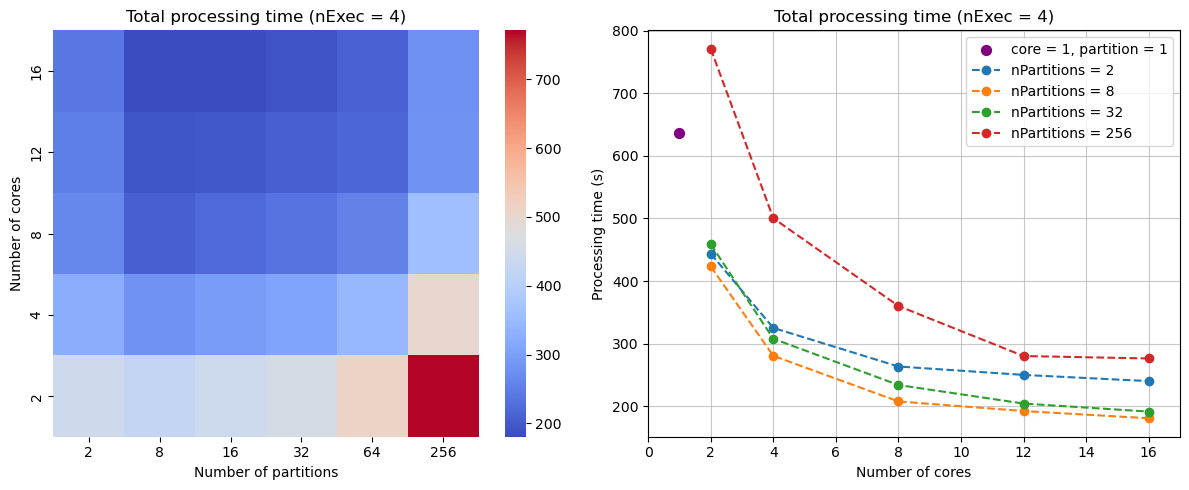

In [5]:
TotalTime = np.reshape(MultiCoreAvgDF['TotalTime'], (5, 6))


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap on the first subplot
sns.heatmap(TotalTime, cmap="coolwarm", ax=ax[0])
ax[0].set_xticklabels(nPartitions)
ax[0].set_yticklabels(nCores)
ax[0].invert_yaxis()
ax[0].set_xlabel('Number of partitions')
ax[0].set_ylabel('Number of cores')
ax[0].set_title("Total processing time (nExec = 4)")

# Line plot on the second subplot

ax[1].scatter(1, SingleCoreAvgDF['TotalTime'], label='core = 1, partition = 1', c = 'purple', s = 50)
for i in [0, 1, 3, 5]:
    ax[1].plot(nCores, TotalTime[:, i], label=f'nPartitions = {nPartitions[i]}', linestyle='--', marker='o')


ax[1].set_xlim(0, 17)
ax[1].grid(True, alpha=0.7)
ax[1].set_xlabel('Number of cores')
ax[1].set_ylabel('Processing time (s)')
ax[1].set_title("Total processing time (nExec = 4)")
ax[1].legend()

plt.tight_layout()
plt.show()

In [21]:
bestMultiCores = MultiCoreAvgDF.iloc[np.argmin(MultiCoreAvgDF['TotalTime'])][:-1]

bestMultiCores

LoadCSV                   19.285086
Pivot                     49.970035
Preprocessing             44.857141
AnomalyDetection          39.312415
Correlations              18.010327
Predictive Maintenance     9.223758
Name: 25, dtype: float64

Text(0, 0.5, 'Process time (s)')

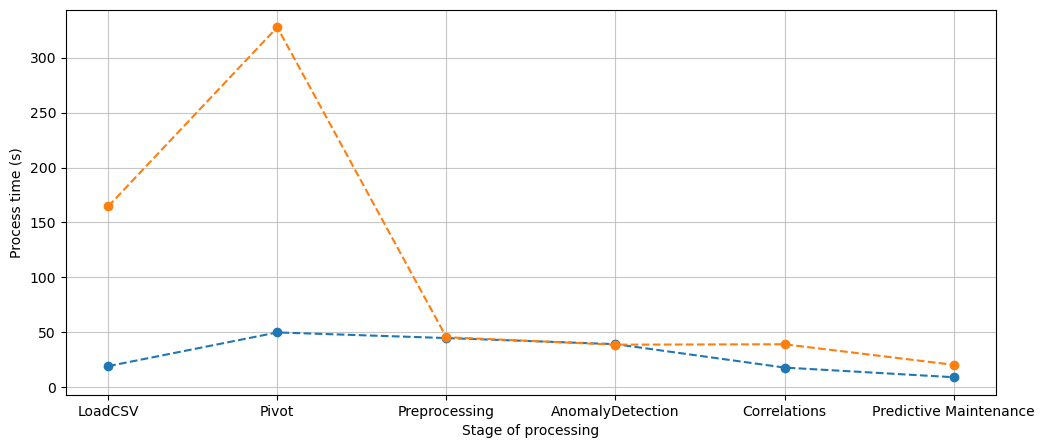

In [8]:
bestMultiCores = AvgDF.iloc[np.argmin(AvgDF['TotalTime'])][:-1]
#Comparison between single core and best multicore result:



SingleCoreTT = SingleCoreAvgDF.iloc[0][:-1]

bestMultiCores = AvgDF.iloc[np.argmin(AvgDF['TotalTime'])][:-1]


plt.figure(figsize = (12, 5))
plt.plot(col, bestMultiCores, label=f'{res[0]} cores, {res[1]} partitions', linestyle='--', marker = 'o')
plt.plot(col, SingleCoreTT, label='1 core, 1 partition', linestyle='--', marker = 'o')
plt.grid(True, alpha = 0.7)
plt.xlabel('Stage of processing')
plt.ylabel('Process time (s)')

In [43]:
nCores = [4, 8, 12, 16]
nExecutors = [2, 4, 6, 8]


Exc1 = pd.read_pickle('CoresExecutors_1.pkl')

res = Exc1.columns.tolist()[0]
col = Exc1.columns.tolist()[1:]

ExecutorsAvgDF['TotalTime'] = Exc1.drop(columns = ['Resources']).sum(axis = 1)


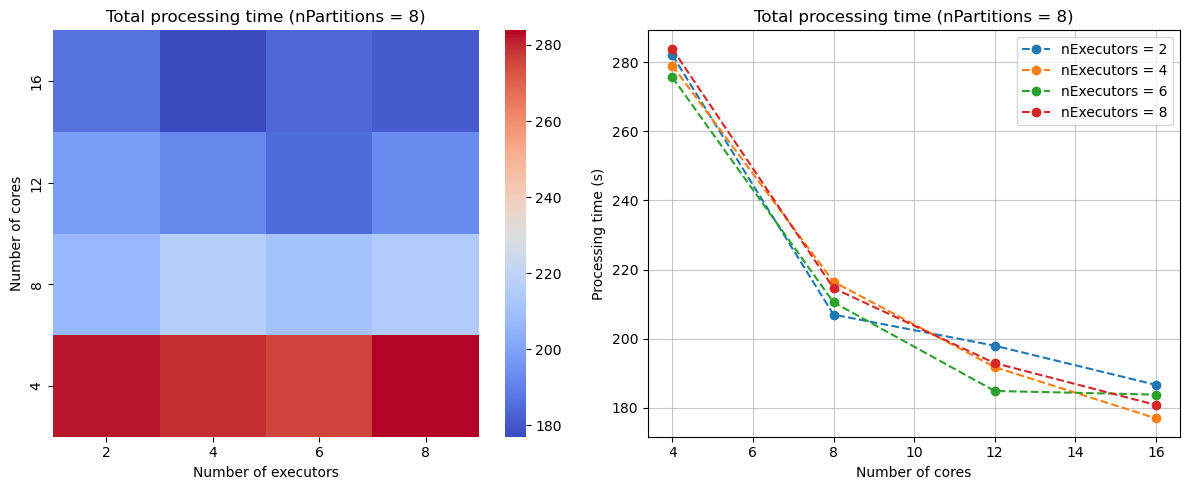

In [45]:
TotalTime = np.reshape(ExecutorsAvgDF['TotalTime'], (4, 4))


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap on the first subplot
sns.heatmap(TotalTime, cmap="coolwarm", ax=ax[0])
ax[0].set_xticklabels(nExecutors)
ax[0].set_yticklabels(nCores)
ax[0].invert_yaxis()
ax[0].set_xlabel('Number of executors')
ax[0].set_ylabel('Number of cores')
ax[0].set_title("Total processing time (nPartitions = 8)")

# Line plot on the second subplot

for i in [0, 1, 2, 3]:
    ax[1].plot(nCores, TotalTime[:, i], label=f'nExecutors = {nExecutors[i]}', linestyle='--', marker='o')


ax[1].grid(True, alpha=0.7)
ax[1].set_xlabel('Number of cores')
ax[1].set_ylabel('Processing time (s)')
ax[1].set_title("Total processing time (nPartitions = 8)")
ax[1].legend()

plt.tight_layout()
plt.show()